## Importing necessary libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install -q pmdarima

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import pathlib
import os
import seaborn as sns
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
sns.set()

## Mounting Google Drive

In [154]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'MachineLearning/DelhiTemperaturePrediction/'

Mounted at /content/gdrive


In [0]:
def displayDirContent(dir):
  if pathlib.posixpath.exists(dir):
    for name in list(pathlib.Path(dir).glob('*')):
      print(name)
  else:
    print("Path does not exists")

In [156]:
displayDirContent(base_dir)

/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Data
/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Models


## Loading Data

In [157]:
data_dir = base_dir + 'Data/'
displayDirContent(data_dir)

/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Data/Weather_data.csv


In [0]:
data = pd.read_csv(data_dir + 'Weather_data.csv')

## Overview to the data

In [159]:
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [160]:
data.tail()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
98908,20161130-12:30,Mist,17.0,0,0,NaN,78.0,NaN,1015.0,0,0,21.0,0,0,1.5,0.0,North,NaN,NaN,0.0
98909,20161130-13:00,Mist,16.0,0,0,NaN,83.0,NaN,1015.0,0,0,19.0,0,0,1.2,0.0,North,NaN,NaN,0.0
98910,20161130-15:00,Patches of Fog,16.0,1,0,NaN,90.0,NaN,1016.0,0,0,17.0,0,0,1.0,NaN,NaN,NaN,NaN,0.0
98911,20161130-18:00,Patches of Fog,14.0,1,0,NaN,96.0,NaN,1017.0,0,0,15.0,0,0,1.0,NaN,NaN,NaN,NaN,0.0
98912,20161130-21:00,Mist,13.0,0,0,NaN,95.0,NaN,1016.0,0,0,14.0,0,0,1.0,NaN,NaN,NaN,NaN,0.0


In [0]:
def overViewOfTheData(data,frows=5,lrows=5):
  print("Shape: ",data.shape,"\n\n")
  
  print("Columns: ",data.columns,"\n\n")

  print("Info : ")
  print(data.info())

In [162]:
overViewOfTheData(data)

Shape:  (98913, 20) 


Columns:  Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object') 


Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 20 columns):
datetime_utc    98913 non-null object
 _conds         98845 non-null object
 _dewptm        98294 non-null float64
 _fog           98913 non-null int64
 _hail          98913 non-null int64
 _heatindexm    29111 non-null float64
 _hum           98160 non-null float64
 _precipm       0 non-null float64
 _pressurem     98682 non-null float64
 _rain          98913 non-null int64
 _snow          98913 non-null int64
 _tempm         98244 non-null float64
 _thunder       98913 non-null int64
 _tornado       98913 non-null int64
 _vism          94497 non-nul

Text(0, 0.5, 'Features')

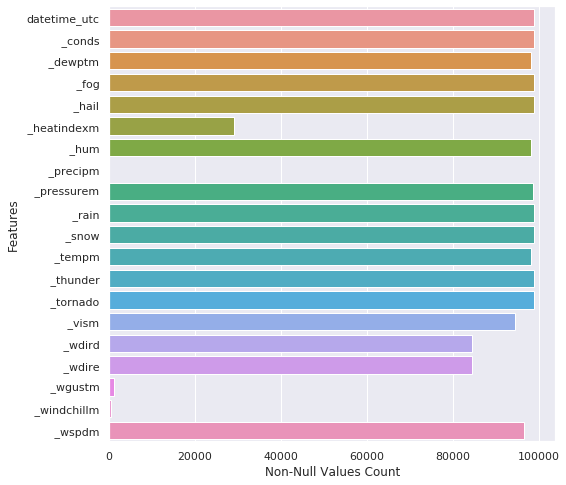

In [163]:
plt.figure(figsize=(8,8))
sns.barplot(x=data.count()[:],y=data.count().index)
plt.xlabel('Non-Null Values Count')
plt.ylabel('Features')

*   Many of the features have a lot of missing values
*   We will remove those features which are having a lot of missing values (heatindexm, precipm, wgustm & windchillm) & we will try to fill missing values in the rest of the features
*   We can see there are some missing values in **temp** also.


In [0]:
data = data.drop([' _heatindexm',' _precipm',' _wgustm',' _windchillm'],axis=1)

## Pre-processing and EDA

In [165]:
# Date-Time column is not in the desired format. So, first we will convert it into the desired format (yyyy-mm-dd HH:MM)
# And the we will make that column the index of the data

data['datetime_utc'] = pd.to_datetime(data['datetime_utc'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))
data['datetime_utc'].head()

0   1996-11-01 11:00:00
1   1996-11-01 12:00:00
2   1996-11-01 13:00:00
3   1996-11-01 14:00:00
4   1996-11-01 16:00:00
Name: datetime_utc, dtype: datetime64[ns]

In [0]:
data = data.set_index('datetime_utc',drop=True)
data.index.name = 'datetime'

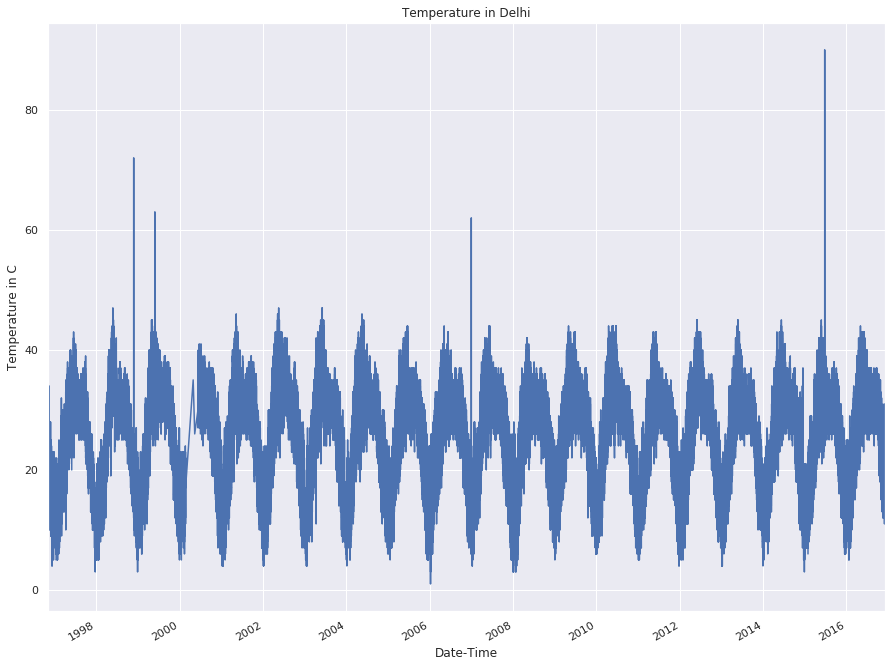

In [167]:
fig, ax = plt.subplots()
data[' _tempm'].plot(figsize=(15,12),ax=ax)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Temperature in C')
ax.set_title('Temperature in Delhi')
plt.show()

*  We can a **seasonal** pattern in the timeseries
*  It is also not continuous as it is having some missing data (ex: between 2000 and 2001)
*  This could be a problem while modeling the timeseries. So, to avoid this we will train our model on the data from the year-2001 as we have enough data for training and there is no significant trend that we will miss by dropping the data before 2001
*  We have some **OUTLIERS** in the series also as we can see some really high temperature values. We will remove these outliers.
*  We have large amount of data but we will only use the necessary data (2013-2016)

In [0]:
# Dropping the data before 2001
data = data['2001':]

In [169]:
# We will remove the missing data and later we will interpolate the temperature for that missing data
print("Before : ", data.shape)
data.dropna(subset=[' _tempm'],inplace=True)
print("After :", data.shape)

Before :  (75852, 15)
After : (75401, 15)


In [170]:
data.index.minute.value_counts()

0     45455
30    29740
21      143
51       29
50       15
40        3
25        3
38        2
20        2
45        1
34        1
32        1
52        1
22        1
15        1
3         1
2         1
53        1
Name: datetime, dtype: int64

*  Here we can see we have **irregular time-intervals**
*  So we will remove the minute time-stamp and will only consider the hourly data

In [172]:
categoricalColumns = list(set(data.columns) - set(data._get_numeric_data().columns))
categoricalColumns

[' _conds', ' _wdire']

In [173]:
# We are resampling it by hours & filling the missing values using the interpolation method
# Notice here we will only get numeric columns so we will have to add the categorical columns additionaly
newdata = data.resample('H').mean().interpolate()
newdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139510 entries, 2001-01-01 00:00:00 to 2016-11-30 21:00:00
Freq: H
Data columns (total 13 columns):
 _dewptm       139510 non-null float64
 _fog          139510 non-null float64
 _hail         139510 non-null float64
 _hum          139510 non-null float64
 _pressurem    139510 non-null float64
 _rain         139510 non-null float64
 _snow         139510 non-null float64
 _tempm        139510 non-null float64
 _thunder      139510 non-null float64
 _tornado      139510 non-null float64
 _vism         139510 non-null float64
 _wdird        139510 non-null float64
 _wspdm        139510 non-null float64
dtypes: float64(13)
memory usage: 14.9 MB


In [174]:
# To resample the categorical data we will consider the firt observation and to fill the missing values we will use ffill method
newdata[list(categoricalColumns)] = data[categoricalColumns].resample('H').first().ffill().head()
newdata.head()

,_dewptm,_fog,_hail,_hum,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wspdm,_conds,_wdire
datetime,,,,,,,,,,,,,,,
2001-01-01 00:00:00,13.0,0.0,0.0,94.0,1011.0,0.0,0.0,14.0,0.0,0.0,1.4,90.0,9.3,Scattered Clouds,East
2001-01-01 01:00:00,12.0,0.0,0.0,94.0,1011.0,0.0,0.0,13.0,0.0,0.0,1.3,70.0,11.1,Scattered Clouds,ENE
2001-01-01 02:00:00,12.0,0.0,0.0,94.0,1012.0,0.0,0.0,13.0,0.0,0.0,1.3,50.0,13.0,Mostly Cloudy,NE
2001-01-01 03:00:00,13.0,0.0,0.0,100.0,1013.0,1.0,0.0,13.0,1.0,0.0,1.0,140.0,5.6,Light Thunderstorms and Rain,SE
2001-01-01 04:00:00,12.0,0.0,0.0,94.0,1014.0,1.0,0.0,13.0,1.0,0.0,1.0,110.0,7.4,Light Thunderstorms and Rain,ESE


In [0]:
def plotAggregateValues(data,column=None):
  if column in data.columns:
    plt.figure(figsize = (18,25))
    
    ax1 = plt.subplot(4,2,1)
    newdata[column].groupby(newdata.index.year).mean().plot(ax=ax1,title='yearly mean values')
    ax1.set_xlabel('years')
    ax1.set_ylabel(column)
  
    ax2 = plt.subplot(4,2,2)
    newdata[column].groupby(newdata.index.month).mean().plot(ax=ax2,title='monthly mean values')
    ax2.set_xlabel('months')
    ax2.set_ylabel(column)

    # ax3 = plt.subplot(4,2,3)
    # newdata[column].groupby(newdata.index.weekday).mean().plot(ax=ax3,title='weekdays mean values')
    # ax3.set_xlabel('weekdays')
    # ax3.set_ylabel(column)

    ax4 = plt.subplot(4,2,4)
    newdata[column].groupby(newdata.index.hour).mean().plot(ax=ax4,title='hourly mean values')
    ax4.set_xlabel('hours')
    ax4.set_ylabel(column)

    # ax5 = plt.subplot(4,2,5)
    # newdata[column].groupby(newdata.index.minute).mean().plot(ax=ax5,title='minute wise mean values')
    # ax5.set_xlabel('minutes')
    # ax5.set_ylabel(column)

    # ax6 = plt.subplot(4,2,6)
    # newdata[column].groupby(newdata.index.second).mean().plot(ax=ax6,title='seconds wise mean values')
    # ax6.set_xlabel('seconds')
    # ax6.set_ylabel(column)

  else:
    print("Column name not specified or Column not in the data")

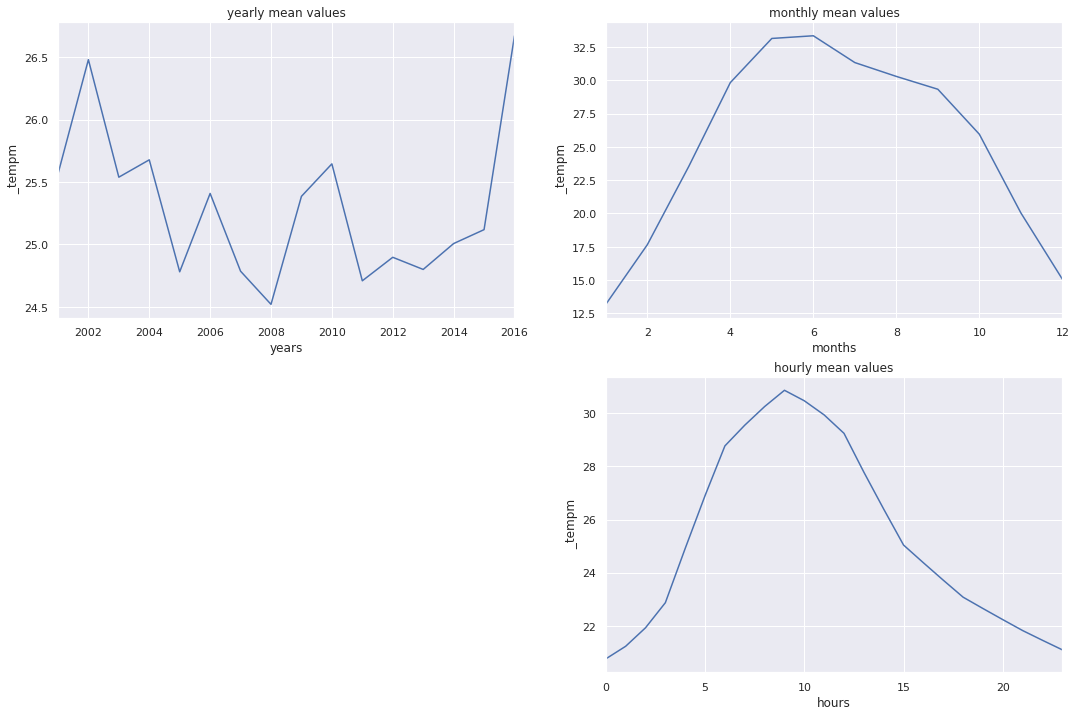

In [176]:
plotAggregateValues(newdata,' _tempm')

*  We can see highest temperature during 5th & 6th month as it is summer time and low temperature during the end and start of the year because of winter.
*  Also, there is high temperature during 11-13 hours as it is noon time and low temperature during night hours.

In [0]:
def plotBoxNdendity(data,col=None):
  if col in data.columns:    
    plt.figure(figsize=(18,8))

    ax1 = plt.subplot(121)
    data.boxplot(col,ax=ax1)
    ax1.set_ylabel('Boxplot temperature levels in Delhi', fontsize=10)

    ax2 = plt.subplot(122)
    data[col].plot(ax=ax2,legend=True,kind='density')
    ax2.set_ylabel('Temperature distribution in Delhi', fontsize=10)

  else:
    print("Column not in the data")

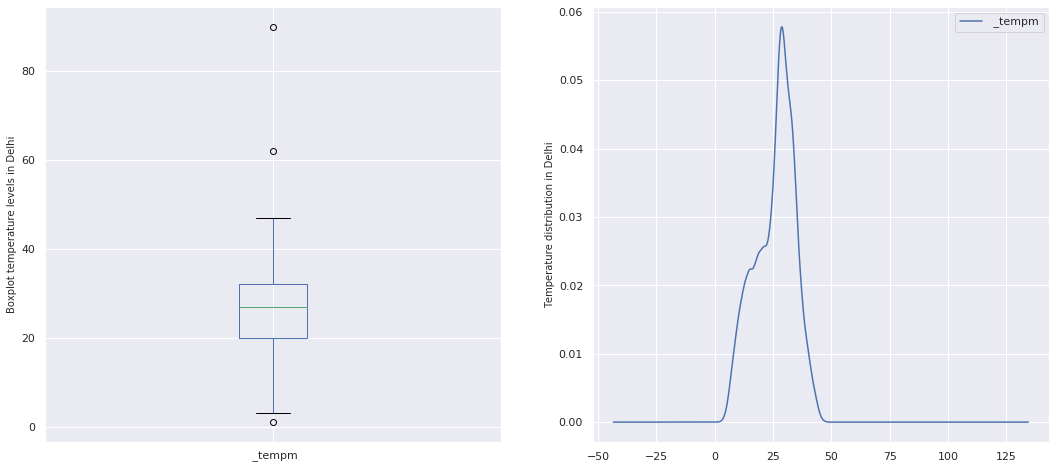

In [178]:
plotBoxNdendity(data,' _tempm')

*  We can observe outliers in box plot which are extremely high.
*  50% of the temperature values are distributed around ~26 C

### Train & Test Split

In [0]:
train = newdata[:'2015']
test = newdata['2016':]


## Model Building 

### 1. Identification

In [0]:
# Let's decompose the time series to visualize trend, season and noise seperately
def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(15,16))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition

In [0]:
# Resampling the data to mothly and averaging out the temperature & we will predict the monthly average temperature
ftraindata = train[' _tempm'].resample('M').mean()
ftestdata = test[' _tempm'].resample('M').mean()

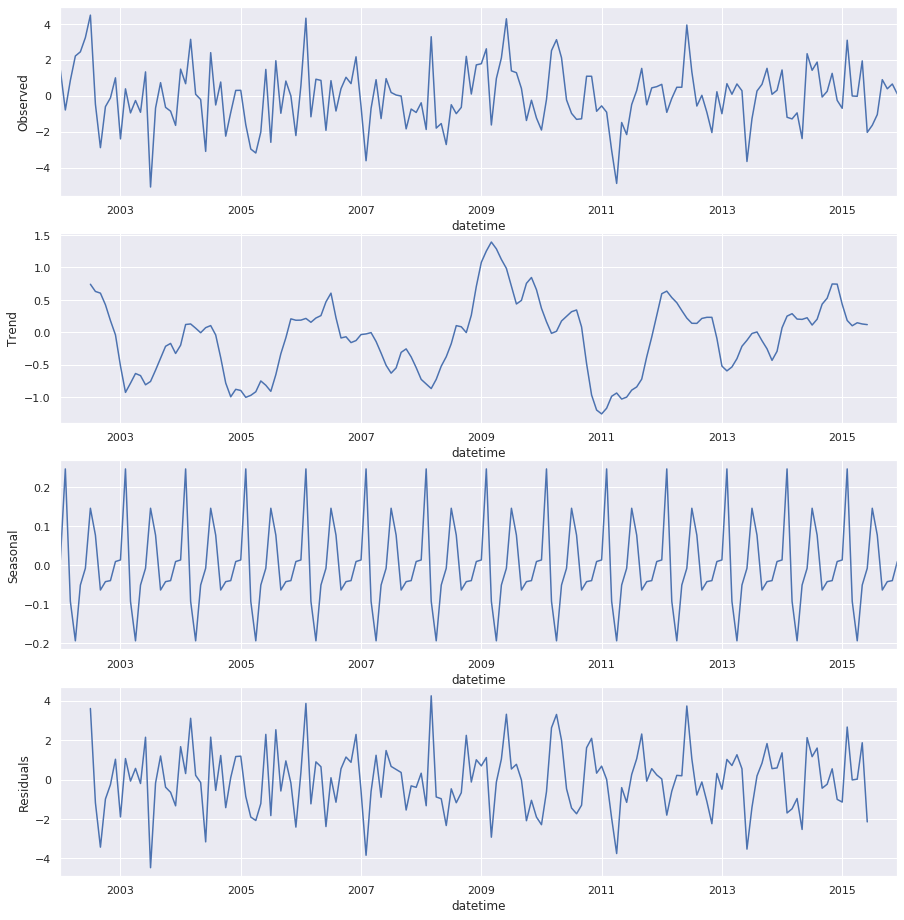

In [183]:
# Taking the seasonal difference S=12 and decomposing the timeseries
decomposition = decomposeNplot(ftraindata.diff(12).dropna())

#### Stationary?

In [184]:
# Let's check for stationarity (Augmented Dickey Fuller test)
results = adfuller(ftraindata.diff(12).dropna())
results

(-6.343758315810132,
 2.7145086550473428e-08,
 11,
 156,
 {'1%': -3.4729792729247793,
  '10%': -2.5767469641683105,
  '5%': -2.8802520918255534},
 530.2085130736691)

* p-value is less than 0.05 and test-statistic is also less very -ev
* So we can say the series is stationary and we can model it without any further transforms 

#### Seasonal?

*  We observed before that there is a yearly periodic pattern -> Seasonal

#### Order of the model?

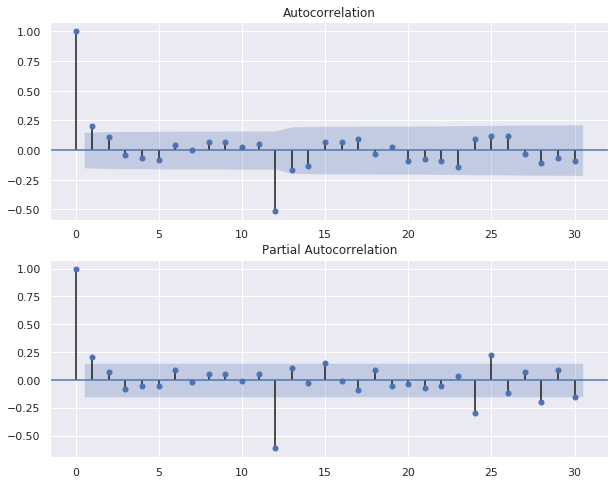

In [185]:
# To get non-seasonal oreders of the SARIMAX Model we will first use ACF & PACF plots
plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=30,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=30,ax=ax2)

*  It's hard to get the idea of the non-seasonal orders from these plots 

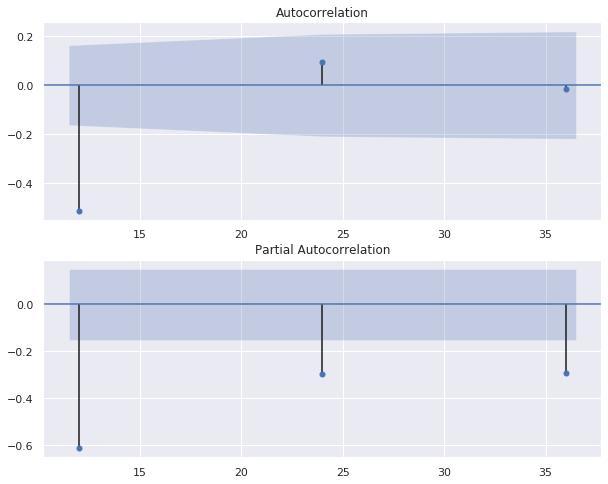

In [186]:
# To get seasonal oreders of the SARIMAX Model we will first use ACF & PACF plots at seasonal lags 

lags = [12*i for i in range(1,4)]

plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=lags,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=lags,ax=ax2)

*  As ACF cuts off after lag 1 & PACF is trailing off we can say that the order of seasonal MA is 1 (Q=1)

### 2. Estimation 

In [0]:
model = SARIMAX(ftraindata,order=(0,0,1),seasonal_order=(0,1,1,12),trend='n')
results = model.fit()

#### Automatic Model Selection

In [189]:
# # Lets select the best model based on the aic & bic scores using auto_arima
# results = pm.auto_arima(ftraindata,
#                       seasonal=True, m=12,
#                       d=0,D=1,trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=562.993, BIC=587.984, Fit time=3.671 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=656.879, BIC=663.127, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=589.360, BIC=601.856, Fit time=0.347 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=558.797, BIC=571.293, Fit time=1.562 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=654.936, BIC=658.060, Fit time=0.025 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=562.246, BIC=584.114, Fit time=3.492 seconds
Near non-invertible roots for order (2, 0, 2)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 

### 3. Diagnostics

In [226]:
# Check the value of Prob(Q) if it is > 0.05 => The residuals are uncorrelated
# Similarly if Prob(JB) > 0.05 => The residuals are normally distributed
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             _tempm   No. Observations:                  180
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -278.353
Date:                            Thu, 30 Jan 2020   AIC                            562.706
Time:                                    20:25:50   BIC                            572.078
Sample:                                01-31-2001   HQIC                           566.510
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2785      0.063      4.400      0.000       0.154       0.403
ma.S.L12      -0.8880      0.101     -8.833      0.000      -1.085      -0.691
sigma2         1.4426      0.183      7.889      0.000       1.084       1.801
===================================================================================
Ljung-Box (Q):                       41.92   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.39   Prob(JB):                         0.57
Heteroskedasticity (H):               0.53   Skew:                             0.20
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [218]:
# Mean Absolute Error for training data
print(np.mean(np.abs(results.resid)))

2.652803238242102


* ~3 *C monthly average temperature error

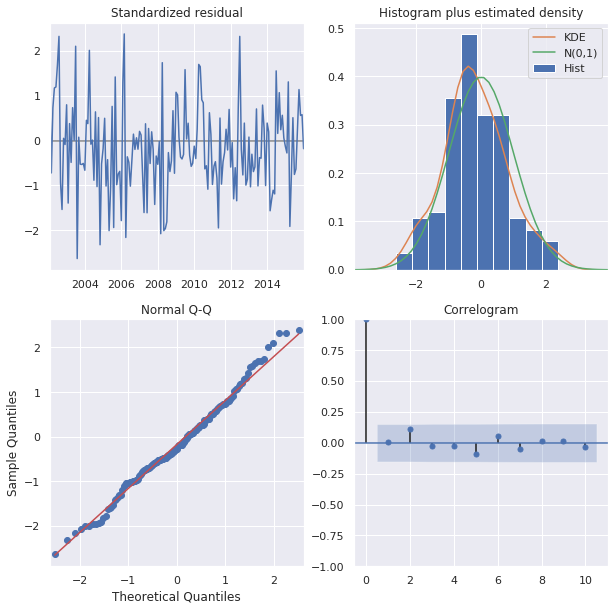

In [219]:
diagnostics = results.plot_diagnostics(figsize=(10,10))

*  Here we can see:   
  1. Standardized residual plot: No obvious structure ✔
  2. Histogram & KDE: KDE is normally distributed ✔
  3. Normal Q-Q: Almost all the points are on the red line ✔
  4. Correlogram of residuals: is nearly zero for all lags ✔ 

### 4. Forecasting

In [0]:
forecast = results.get_forecast(steps=len(ftestdata))

In [0]:
predictedmean = forecast.predicted_mean
bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]

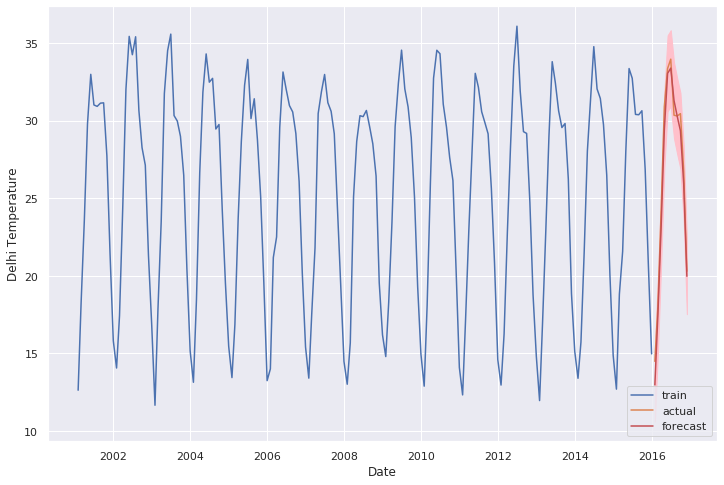

In [229]:
plt.figure(figsize=(12,8))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(ftestdata.index,ftestdata,label='actual')

plt.plot(predictedmean.index, predictedmean, color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')

plt.xlabel('Date')
plt.ylabel('Delhi Temperature')
plt.legend()
plt.show()

### 5. Saving the model

In [230]:
displayDirContent(base_dir)

/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Data
/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Models


In [231]:
filename = 'SARIMA_0_0_1_0_1_1_12.pkl'
joblib.dump(results,filename = base_dir + 'Models/' + filename)

['/content/gdrive/My Drive/MachineLearning/DelhiTemperaturePrediction/Models/SARIMA_0_0_1_0_1_1_12.pkl']